In [1]:
from keras.models import Sequential
from keras.layers import Conv1D,Input,Dense,Flatten
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [2]:
sample_length = 128

In [33]:
aggregate_power = pd.read_csv('../master_data/house_1/channel_1.dat', header = None,
                                names = ["Time","Power"], delim_whitespace = True,
                                index_col = 0)
aggregate_power.index = pd.to_datetime(aggregate_power.index,unit='s')
#mw_activations = pd.read_csv('../master_data/nilm/mw_activations.dat', #header = None,
#                                delim_whitespace = True,
#                                names = ['index', 'start','end','mean_power'],
#                                index_col = 0)
kettle_activations = pd.read_csv('../master_data/nilm/kettle_activations.dat', header = 0,
                                delim_whitespace = True,
                                names = ['index', 'start','end','mean_power'],
                                index_col = 0, parse_dates = ['start','end'],
                                date_parser = pd.core.tools.datetimes.to_datetime)
#dw_activations = pd.read_csv('../master_data/nilm/dw_activations.dat', #header = None,
#                                delim_whitespace = True,
#                                names = ['index', 'start','end','mean_power'],
#                                index_col = 0)
kettle_activations.head()

/home/bjornif/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,start,end,mean_power
index,,,
0,2012-11-10 08:49:42,2012-11-10 08:51:45,2311.157895
1,2012-11-10 17:22:40,2012-11-10 17:24:05,2282.692308
2,2012-11-11 08:28:41,2012-11-11 08:30:47,2261.200000
3,2012-11-11 11:35:09,2012-11-11 11:38:09,2282.896552
4,2012-11-11 11:44:35,2012-11-11 11:46:59,2285.956522


In [32]:
(kettle_activations['end'] - kettle_activations['start']).sort_values().tail(40)

index
2888   00:04:38
2320   00:04:38
3195   00:04:38
3085   00:04:39
2913   00:04:40
3277   00:04:41
2542   00:04:43
2939   00:04:46
3060   00:04:46
652    00:04:46
1838   00:04:49
564    00:04:51
3009   00:04:55
2777   00:04:57
3270   00:04:59
3117   00:04:59
1491   00:05:00
3137   00:05:01
2928   00:05:02
53     00:05:11
2114   00:05:14
3103   00:05:18
2988   00:05:23
1712   00:05:24
3036   00:05:32
3019   00:05:33
3140   00:05:33
3077   00:06:19
1250   00:06:19
105    00:06:22
1133   00:06:22
1566   00:06:26
355    00:06:28
1063   00:07:16
1193   00:07:17
2344   00:07:49
1490   00:07:54
1221   00:07:58
1119   00:08:57
3092   00:11:25
dtype: timedelta64[ns]

#### Note:
The minimal run time of the kettle is 30 seconds.

It is not entirely clear to me how the authors of the paper created their training sets (only that they extended them substantially with syntethic data). Below is an attempt to create a training set in the spirit of the paper, by randomly selecting "empty" and "meaningful" intervals with a 50/50 probability.

In [37]:
def clean_power_series(aggregate_power, activations):
    
    temp_ap = aggregate_power.copy()
    
    n = activations.shape[0]

    #pcent = int(n/100)
    ap_sans_activations = pd.DataFrame()
    
    ap_sans_activations.append(temp_ap[:activations['start'][0]])
    
    for i in range(1,n):
        ap_sans_activations = ap_sans_activations.append(temp_ap[activations['end'][i-1]:activations['start'][i]])
    
    ap_sans_activations.append(temp_ap[activations['end'][i]:])
    
    return ap_sans_activations


def create_training_set(aggregate_power, activations, ap_sans_activations = None, sample_length = 128, pad = 1024):
    training_set = pd.DataFrame(columns = np.linspace(0,1,sample_length))
    training_set_response = pd.DataFrame(columns = ['start','end','mean_power'])

    #aggregate power sans the activation intervals
    if ap_sans_activations is None:
        ap_sans_activations = clean_power_series(aggregate_power,activations)

    n = aggregate_power.shape[0]
    j = 0
    for i in range(activations.shape[0]):
        if i % 100 == 0:
            print(i)
        while True:
            dice = np.random.random()
            if dice < 0.5:
                start = activations['start'][i]
                end = activations['end'][i]
                #randomly place the chosen signal in a window.
                #note that the entire signal is always in the window 
                sample_start = start - pd.Timedelta(np.random.randint(0,pad),unit='s')
                sample_end = end + pd.Timedelta(np.random.randint(0,pad),unit='s')
                sample = aggregate_power[sample_start:sample_end]

                while sample.shape[0] > sample_length:
                    if np.random.random() > 0.5 and end < sample.index[-1]:
                        sample = sample.iloc[:-1]
                    elif start > sample.index[0]:
                        sample = sample.iloc[1:]
                    else:
                        sample = sample.iloc[0:1]
                
                if not sample.shape[0] < sample_length:
                    
                    #sample = sample.reindex(columns=training_set.columns, method='nearest')
                    start_fraction = (start - sample.index[0])/(sample.index[-1] - sample.index[0])
                    end_fraction = (end - sample.index[0])/(sample.index[-1] - sample.index[0])
                    training_set.loc[j] = sample.T.values[0]
                    training_set_response.loc[j] = [start_fraction,end_fraction,activations['mean_power'][i]]
                    j+=1
                    break
                
            ri = np.random.randint(0,ap_sans_activations.shape[0]-sample_length)
            sample = ap_sans_activations.iloc[ri: ri+sample_length]
            training_set.loc[j] = sample.T.values[0]
            training_set_response.loc[j] = [0,0,0]
            j+=1
            
    return training_set, training_set_response



#### Note: 
drop() takes forever, avoid it.<br>


In [38]:
clean_ap = clean_power_series(aggregate_power,kettle_activations)

In [36]:
training_set_kettle, response_kettle = create_training_set(aggregate_power, kettle_activations,
                                                           ap_sans_activations = clean_ap,
                                                          sample_length = sample_length)
training_set_kettle.head()

0
100


KeyboardInterrupt: 

### Normalization:

As per the paper, done by subtracting sample mean and dividing by a <i>random</i> sample standard deviation.

In [ ]:
syntethic_data = pd.read_csv('../master_data/nilm/syntethic_data.dat', header = None,
                                names = ["Time","Power"], delim_whitespace = True,
                                index_col = 0)
syntethic_response = pd.read_csv('../master_data/nilm/syntethic_response.dat', header = None,
                                names = ["Time","Power"], delim_whitespace = True,
                                index_col = 0)

In [ ]:
row_mean = syntethic_data.mean(axis=1)
syntethic_data_n = syntethic_data.sub(row_mean.T,axis=0)
rand_sd = syntethic_data.std(axis=1)
rand_sd = rand_sd.sample(frac=1).reset_index(drop=True)
syntethic_data_n = syntethic_data_n.div(rand_sd,axis=0)
syntethic_data_n.head()



In [294]:
row_mean = training_set_kettle.mean(axis=1)
training_set_kettle_n = training_set_kettle.sub(row_mean.T,axis=0)
rand_sd = training_set_kettle.std(axis=1)
rand_sd = rand_sd.sample(frac=1).reset_index(drop=True)
training_set_kettle_n = training_set_kettle_n.div(rand_sd,axis=0)
training_set_kettle_n.head()



,0.0,0.00787401574803,0.0157480314961,0.0236220472441,0.0314960629921,0.0393700787402,0.0472440944882,0.0551181102362,0.0629921259843,0.0708661417323,...,0.929133858268,0.937007874016,0.944881889764,0.952755905512,0.96062992126,0.968503937008,0.976377952756,0.984251968504,0.992125984252,1.0
0,-0.0214831,-0.0102801,-0.0601845,-0.0540737,-0.0561106,-0.0102801,-0.0561106,-0.0459261,-0.0265754,-0.0438891,...,-0.012317,-0.0377784,-0.0204646,0.0111076,-0.00416931,-0.00620622,-0.034723,-0.0143539,-0.0337046,-0.0225015
1,331.852,1650.3,1634.83,1638.09,1634.83,1625.06,1639.72,1633.2,1642.16,1643.79,...,-259.374,-254.488,-261.817,-252.045,-240.644,-222.728,-226.8,-240.644,-239.83,-253.674
2,-13.3266,-13.2959,-13.4188,-14.8934,-14.7091,-14.5862,-14.8934,-14.7091,-14.7398,-14.6169,...,-3.55721,-3.95659,-3.98731,-4.23308,-13.2652,-3.09639,-2.88134,-2.66629,-2.38979,-2.26691
3,-0.00337079,-0.00152694,0.000316912,0.00216076,0.000316912,-0.00152694,-0.00244886,-0.00152694,-0.00152694,-0.00244886,...,0.00492653,0.00123884,-0.00152694,-0.00152694,-0.00152694,0.00308269,0.00216076,0.000316912,0.00123884,-0.00244886
4,-24.7811,-24.8169,-24.7811,-24.6739,-24.8169,-24.7811,-24.7096,-24.7454,-24.7811,-24.7811,...,-23.7086,-23.6014,-23.7444,-23.6729,-23.6729,-23.6014,-23.6371,-23.6729,-23.6014,-23.6014


In [296]:
data = pd.concat([training_set_kettle,response_kettle],axis=1)
data = data.sample(frac=1).reset_index(drop=True)

split = int(data.shape[0]*0.75)
training_set = data[:split]
test_set = data[split:]

X_train = training_set.iloc[:,:-3]
y_train = training_set.iloc[:,-3:]

X_test = test_set.iloc[:,:-3]
y_test = test_set.iloc[:,-3:]

X_train_np = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
y_train_np = np.array(y_train).reshape((y_train.shape[0],y_train.shape[1]))

In [122]:
#Tensorflow uses shape [samples][height][width][channels] 

layer1 = Conv1D(filters=16, input_shape = (sample_length,1,),kernel_size=4,
                activation='linear',padding='valid', strides=1)
layer2 = Conv1D(filters=16, kernel_size=4,activation='linear',padding='valid', strides=1)
layer2_b = Flatten()
layer3 = Dense(units=4096,activation='relu')
layer4 = Dense(units=3072,activation='relu')
layer5 = Dense(units=2048,activation='relu')
layer6 = Dense(units=512,activation='relu')
outputs = Dense(units=3,activation='linear')

model = Sequential()

model.add(layer1)
model.add(layer2)
model.add(layer2_b)
model.add(layer3)
model.add(layer4)
model.add(layer5)
model.add(layer6)
model.add(outputs)

In [123]:


print(X_train_np.shape, y_train_np.shape)
model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['mae'])

model.fit(X_train_np, y_train_np, batch_size=64,verbose=1,epochs=100)

(4174, 128, 1) (4174, 3)
Epoch 1/100
4174/4174 [==============================] - 36s 9ms/step - loss: 86601879538810.2812 - mean_absolute_error: 636367.9313
Epoch 2/100
4174/4174 [==============================] - 37s 9ms/step - loss: 182946.9260 - mean_absolute_error: 180.9302
Epoch 3/100
4174/4174 [==============================] - 38s 9ms/step - loss: 145838.0156 - mean_absolute_error: 152.8009
Epoch 4/100
4174/4174 [==============================] - 37s 9ms/step - loss: 125828.7529 - mean_absolute_error: 135.0234
Epoch 5/100
4174/4174 [==============================] - 36s 9ms/step - loss: 115390.0377 - mean_absolute_error: 123.7351
Epoch 6/100
4174/4174 [==============================] - 37s 9ms/step - loss: 110686.6972 - mean_absolute_error: 118.8584
Epoch 7/100
4174/4174 [==============================] - 37s 9ms/step - loss: 103927.0839 - mean_absolute_error: 113.7689
Epoch 8/100
4174/4174 [==============================] - 38s 9ms/step - loss: 99892.7351 - mean_absolute_error

[16.84370231628418 10.290209770202637 261.28966331421816 166.36993912014486
 7.184263229370117 12.449307441711426 13.967791557312012 11.131338119506836
 568.0872065814519 3.9570608139038086]


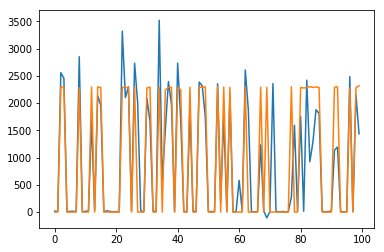

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [302]:
X_test_np = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))
y_test_np = np.array(y_test).reshape((y_test.shape[0],y_test.shape[1]))

#model.evaluate(X_test_np,y_test_np, batch_size=64, verbose=1)
pred = model.predict(X_test_np)

diff_v = pred[:,2] - y_test_np[:,2]
diff_s = pred[:,0] - y_test_np[:,0]
diff_e = pred[:,1] - y_test_np[:,1]
#print(pred[:10])
print(diff_v[:10])
mae = sum(abs(pred - y_test_np))/pred.shape[0]

#print(mae)

plt.plot(pred[:100,2])
plt.plot(y_test_np[:100,2])
plt.show()

plt.fill_between(np.arange(200),diff_v[:200],where=(diff_v[:200] >= 0),color='green')
plt.fill_between(np.arange(200),diff_v[:200],where=(diff_v[:200] < 0),color='red')
plt.show()

plt.fill_between(np.arange(200),diff_s[:200],where=(diff_s[:200] >= 0),color='green')
plt.fill_between(np.arange(200),diff_e[:200],where=(diff_e[:200] < 0),color='red')
#plt.axhline(1)
#plt.axhline(-1)
plt.show()

In [168]:
model.save('model3.h5')

More data is clearly needed in order to train an adequate model, however the model does seem to be fairly good at identifying whether or not a signal is present.

In [177]:
from keras.models import load_model

prev_model = load_model('model2.h5')

0.0


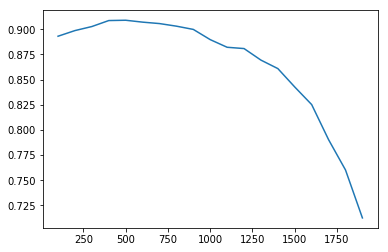

In [307]:
#F1 score = 2*(recall*precision)/(recall+precision)
signal_present_gold = np.zeros(pred.shape[0])
signal_present_gold[np.where(y_test_np[:,2] > 0)] = 1
signal_present_pred = np.zeros(pred.shape[0])
signal_present_pred[np.where(pred[:,2] >= 100)] = 1

#print(np.where(signal_present_gold == 1) and np.where(signal_present_pred == 1))
#print(signal_present_pred)
accs = []
thresholds = np.arange(100,2000,100)

for i in thresholds:
    signal_present_pred = np.zeros(pred.shape[0])
    signal_present_pred[np.where(pred[:,2] >= i)] = 1
    
    precision = signal_present_gold[signal_present_gold + signal_present_pred == 2].shape[0]/np.sum(signal_present_pred)
    recall = signal_present_gold[signal_present_gold + signal_present_pred == 2].shape[0]/np.sum(signal_present_gold)
    f1 = 2*(recall*precision)/(recall+precision)
    
    accs.append(f1)
    

print(signal_present_gold_ds.sum()/signal_present_gold_ds.shape[0])
plt.plot(thresholds,accs)
plt.xticks = thresholds
plt.show()


#precision = signal_present_gold[signal_present_gold + signal_present_pred == 2].shape[0]/np.sum(signal_present_pred)
#recall = signal_present_gold[signal_present_gold + signal_present_pred == 2].shape[0]/np.sum(signal_present_gold)
#f1 = 2*(recall*precision)/(recall+precision)
#print("Precision: ", precision)
#print("Recall: ", recall)
#print("F1: ", f1)
#print(sum(signal_present_gold == signal_present_pred)/pred.shape[0])


As seen above, the model acheives a decent classification result by thresholding at around 500 kW.

## Downsampling

In the following section, I wattempt to downsample the signal and observe the change in accuracy (since this was the only metric in which the net acheived a decent score) when testing the model trained on the high-frequency data on the downsampled time series.

In [1]:
aggregate_power_ds = aggregate_power.resample('2min').mean()
sample_length = 128
print(aggregate_power_ds.size)
training_set_kettle_ds, response_kettle_ds = create_training_set(aggregate_power_ds, kettle_activations,
                                                          sample_length = sample_length, pad = 50000)
training_set_kettle_ds.head()

NameError: name 'aggregate_power' is not defined

In [329]:
row_mean = training_set_kettle_ds.mean(axis=1)
training_set_kettle_ds_n = training_set_kettle_ds.sub(row_mean.T,axis=0)
rand_sd = training_set_kettle_ds.std(axis=1)
rand_sd = rand_sd.sample(frac=1).reset_index(drop=True)
training_set_kettle_ds_n = training_set_kettle_ds_n.div(rand_sd,axis=0).dropna()
training_set_kettle_ds_n.size


388608

In [335]:

data_ds = pd.concat([training_set_kettle_ds,response_kettle_ds],axis=1)
data_ds = data_ds.sample(frac=1).reset_index(drop=True)

split = int(data_ds.shape[0]*0.75)
training_set_ds = data_ds[:split]
test_set_ds = data_ds[split:]

X_ds = test_set_ds.iloc[:,:-3]
y_ds = test_set_ds.iloc[:,-3:]


,start,end,mean_power
2553,0,0,0
2554,0,0,0
2555,0,0,0
2556,0,0,0
2557,0,0,0
2558,0,0,0
2559,0,0,0
2560,0,0,0
2561,0,0,0
2562,0,0,0


In [325]:
X_ds = np.array(X_ds).reshape((X_ds.shape[0],X_ds.shape[1],1))
y_ds = np.array(y_ds)

pred_ds = pred = model.predict(X_ds)


#print(y_ds[:,2][y_ds[:,2] > 0].min())


[48.905948638916016 698.433837890625 3.0191001892089844 10.668148040771484
 696.7069091796875 31.583616256713867 794.8026733398438 11.881888389587402
 nan 5.796083450317383]


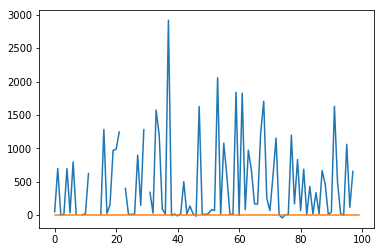

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [326]:
X_test_np = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))
y_test_np = np.array(y_test).reshape((y_test.shape[0],y_test.shape[1]))

#model.evaluate(X_test_np,y_test_np, batch_size=64, verbose=1)
pred = model.predict(X_test_np)

diff_v = pred[:,2] - y_test_np[:,2]
diff_s = pred[:,0] - y_test_np[:,0]
diff_e = pred[:,1] - y_test_np[:,1]
#print(pred[:10])
print(diff_v[:10])
mae = sum(abs(pred - y_test_np))/pred.shape[0]

#print(mae)

plt.plot(pred[:100,2])
plt.plot(y_test_np[:100,2])
plt.show()

plt.fill_between(np.arange(200),diff_v[:200],where=(diff_v[:200] >= 0),color='green')
plt.fill_between(np.arange(200),diff_v[:200],where=(diff_v[:200] < 0),color='red')
plt.show()

plt.fill_between(np.arange(200),diff_s[:200],where=(diff_s[:200] >= 0),color='green')
plt.fill_between(np.arange(200),diff_e[:200],where=(diff_e[:200] < 0),color='red')
#plt.axhline(1)
#plt.axhline(-1)
plt.show()

In [327]:
signal_present_gold = np.zeros(pred_ds.shape[0])
signal_present_gold[np.where(y_ds[:,2] > 0)] = 1

accs = []
thresholds = np.arange(100,5000,100)

for i in thresholds:
    signal_present_pred = np.zeros(pred_ds.shape[0])
    signal_present_pred[np.where(pred_ds[:,2] >= i)] = 1
    print(signal_present_gold[signal_present_gold + signal_present_pred == 2])
    precision = signal_present_gold[signal_present_gold + signal_present_pred == 2].shape[0]/np.sum(signal_present_pred)
#    recall = signal_present_gold[signal_present_gold + signal_present_pred == 2].shape[0]/np.sum(signal_present_gold)
#    f1 = 2*(recall*precision)/(recall+precision)
    
#    accs.append(f1)

#plt.plot(thresholds,accs)
#plt.show()

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


/home/bjornif/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
